# Eye state detection classifier comparison

In [24]:
%matplotlib inline

import numpy as np
import pandas as pd

random_seed = 123
np.random.seed(random_seed)

import warnings
warnings.filterwarnings('ignore')

In [25]:
train = pd.read_csv("eeg_train.csv")

X = train.sample(frac=1).copy()
y = X.pop("label")

### Preprocess features

First we remove the outliers and fit a StandardScaler on the train set. 

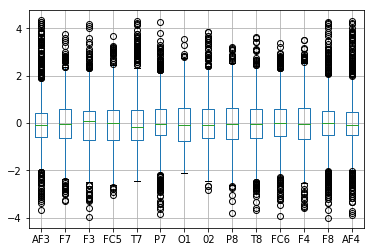

In [26]:
from scipy import stats
from sklearn import preprocessing

nonoutliers = (np.abs(stats.zscore(X)) < 3).all(axis=1)
X_clean = X[nonoutliers]
y_clean = y[nonoutliers]

scaler = preprocessing.StandardScaler()
scaler.fit(X_clean)
X_norm = pd.DataFrame(scaler.transform(X_clean),columns=X_clean.columns)

X_norm.boxplot()

Then we apply **the fitted** StandardScaler on the test set.

In [27]:
test = pd.read_csv("eeg_test.csv")

index_col = test.pop("index")
X_test = scaler.transform(test)

Next we evaluate some Machine Learning algorithms.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "LR": LogisticRegression(solver='lbfgs'),
    "SVM": SVC(probability=True), #make sure to output probabilities
    "RF": RandomForestClassifier(),
    "GB": GradientBoostingClassifier()
}

hyperparams = {
    "LR":{
        "C":[0.001,0.01,0.1,1,10]
    },
    "SVM":{
        "kernel":['rbf'],
        "C":[0.001,0.01,0.1,1,10],
        "gamma":[0.01,0.05,0.1,0.5]
    },
    "RF":{
        "n_estimators":[100],
        "max_features":[3,6,9,12,14]
    },
    "GB":{
        "n_estimators":[100,200,300],
        "learning_rate":[0.01,0.1,0.3],
        "max_depth":[3,6,9]
    }    
}

I split the training set in a 90% train and 10% validation part.

In [29]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=.1, random_state=random_seed)

Then I optimize the hyperparameters on the 90% train part using 3-fold cross-validation.

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

CV = 3

for cls_name in classifiers:
    cls = GridSearchCV(classifiers[cls_name],hyperparams[cls_name],cv=CV,scoring="roc_auc",verbose=1)
    cls.fit(train_X,train_y)
    predictions = cls.best_estimator_.predict_proba(val_X)
    print("%s\tCV=%f\tVAL=%f"%(cls_name,cls.best_score_,roc_auc_score(val_y,predictions[:,1])))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LR	CV=0.668267	VAL=0.623698
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   40.4s finished


SVM	CV=0.921925	VAL=0.932442
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    9.4s finished


RF	CV=0.905322	VAL=0.949870
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.1min finished


GB	CV=0.916173	VAL=0.939603
